### First implementaiton 

In [1]:
%load_ext autoreload
%autoreload 2

In [148]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
import pandas as pd
import cv2
from skimage import io, color
from utils import show_landmarks
from utils import prep_landmarks, show_landmarks, load_img

cudnn.benchmark = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Getting the data

In [3]:
root_dir = 'data/training/'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv("data/training_frames_keypoints.csv")

In [4]:
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


## Dataset and Tranforms 

In [149]:
class FacesDataset(Dataset):
    """Face landmarks dataset"""
    
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.root_dir,
                               self.df.iloc[idx, 0])
        img = color.rgba2rgb(io.imread(img_path))
        landmarks = self.df.iloc[idx, 1:]
        landmarks = np.array(landmarks).astype('float').reshape(-1, 2)
        sample = {'image': img, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample['image'], sample['landmarks']

In [164]:
class Rescale(object):
    """Rescale the image in a sample to a given size with matching landmarks"""
    
    def __init__(self, output_size):
        assert isinstance(output_size, tuple)
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        # scalling the image
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        img = transform.resize(image, (new_h, new_w))
        
        # scalling the landmarks
        landmarks = landmarks * [new_w / w, new_h / h]
        
        return {'image': img, 'landmarks': landmarks}

class RandomCrop(object):
    """Crop randomly the image in sample"""
    def __init__(self, output_size):
        assert isinstance(output_size, (tuple, int))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, abs(h - new_h))
        left = np.random.randint(0, abs(w - new_w))
        
        
        image = image[top: top+new_h, left: left+new_w]
        
        landmarks = landmarks - [left, top]
        
        return {'image': image, 'landmarks': landmarks/224}
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors"""
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).float() / 255.,
               'landmarks': torch.flatten(torch.from_numpy(landmarks))}

In [165]:
from sklearn.model_selection import train_test_split

tfms = transforms.Compose([
    Rescale((256, 256)),
    RandomCrop(224),
    ToTensor()
])

train, valid = train_test_split(data, test_size=0.2, random_state=42)
train_dataset = FacesDataset(train.reset_index(drop=True), root_dir, tfms)
valid_dataset = FacesDataset(valid.reset_index(drop=True), root_dir, tfms)

train_loader = DataLoader(train_dataset, batch_size=32)
valid_loader = DataLoader(valid_dataset, batch_size=32)

dataloaders = {'train': train_loader, 'val': valid_loader}
datasets_sizes = {'train': len(train_dataset), 'val': len(valid_dataset)}
datasets_sizes

{'train': 2769, 'val': 693}

In [168]:
xb, yb = next(iter(train_loader))
xb.shape, yb.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 136]))

In [169]:
# only works if not using transforms 
# fig = plt.figure()
# for i in range(len(train_dataset)):
#     image, keypoints = train_dataset[i]
    
#     print(i, sample['image'].shape, sample['landmarks'].shape)
    
#     ax = plt.subplot(1, 4, i+1)
#     plt.tight_layout()
#     ax.set_title('Sample #{}'.format(i+1))
#     ax.axis('off')
#     show_landmarks(**sample)
    
#     if i == 3:
#         plt.show()
#         break

In [170]:
# only works if not using transforms 
# scale = Rescale((256, 256))
# crop = RandomCrop(224)
# composed = transforms.Compose([Rescale((256, 256)),
#                                RandomCrop(224)])

# fig = plt.figure()
# sample = train_dataset[100]
# for i, tfms in enumerate([scale, crop, composed]):
#     transformed_sample = tfms(sample)
    
#     ax = plt.subplot(1, 3, i+1)
#     plt.tight_layout()
#     ax.set_title(type(tfms).__name__)
#     show_landmarks(**transformed_sample)
# plt.show()

## Model

In [171]:
def get_model():
    model = models.vgg16(weights='VGG16_Weights.DEFAULT')
    for param in model.parameters():
        param.requires_grad = False

    model.avgpool = nn.Sequential(
      nn.Conv2d(512, 512, 3),
      nn.MaxPool2d(2),
      nn.Flatten()
    )

    model.classifier = nn.Sequential(
      nn.Linear(2048, 512),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(512, 136),
      nn.Sigmoid()
    )

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    return model.to(device), criterion, optimizer, exp_lr_scheduler

In [172]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    train_losess = []
    valid_losses = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*10)
        
        # train and val phases
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0

            # iterate over data
            for inputs, points in dataloaders[phase]:
                inputs = inputs.to(device)
                points = points.to(device)

                # zero the parameters gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    _points = model(inputs)
                    loss = criterion(_points, points)

                    # backward + optimize if only in train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # stats
                running_loss += loss.item() * inputs.size(0)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / datasets_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f}')
            
            if phase == 'train':
                train_losess.append(epoch_loss)
            else:
                valid_losses.append(epoch_loss)

            # keep the best model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Loss: {best_loss:.4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    # save model's best weight to desk
    torch.save(model.state_dict(), 'models/02.pth')
    return model, train_losess, valid_losses

In [178]:
model, criterion, optimizer, exp_lr_scheduler = get_model()

In [ ]:
model, train_losses, valid_losess = train_model(model, criterion, optimizer,
                                               exp_lr_scheduler, 50)

Epoch 0/49
----------
train Loss: 0.0794
val Loss: 0.0605

Epoch 1/49
----------
train Loss: 0.0653
val Loss: 0.0588

Epoch 2/49
----------
train Loss: 0.0638
val Loss: 0.0579

Epoch 3/49
----------
train Loss: 0.0624
val Loss: 0.0579

Epoch 4/49
----------
train Loss: 0.0619
val Loss: 0.0584

Epoch 5/49
----------
train Loss: 0.0622
val Loss: 0.0579

Epoch 6/49
----------
train Loss: 0.0612
val Loss: 0.0590

Epoch 7/49
----------
train Loss: 0.0613
val Loss: 0.0583

Epoch 8/49
----------
train Loss: 0.0619
val Loss: 0.0573

Epoch 9/49
----------
train Loss: 0.0609
val Loss: 0.0585

Epoch 10/49
----------
train Loss: 0.0604


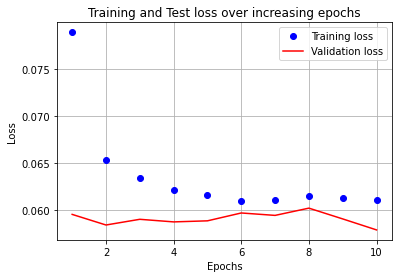

In [175]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, valid_losess, 'r', label='Validation loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

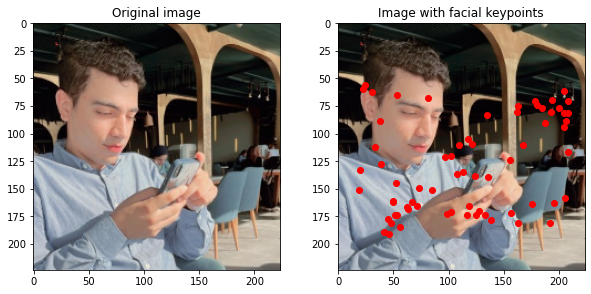

In [177]:
# ix = 3
img_path = 'data/test_imgs/moaz.jpg'
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
# im = test_dataset.load_img(ix)
img = load_img(img_path)
plt.imshow(img)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
plt.imshow(img)
img = load_img(img_path, infer=True)
model.eval()
with torch.no_grad():
    kp = model(img[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()